# Best Algorithm

This notebook will test several algorithms and compare their performance. Afterwards, the best algorithm will be trained with different parameters.

We will use the 24 previous hours to train the models in the first phase. We will also only use one location, for faster development.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12.8, 7.2)

import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

# import XGBoost
import xgboost as xgb

# import Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# import Artificial Neural Network
from sklearn.neural_network import MLPRegressor

# import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# import random forest
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_pickle("../data/df_24h.pkl")
df.head()


,location,time,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,...,energy_lag_39,energy_lag_40,energy_lag_41,energy_lag_42,energy_lag_43,energy_lag_44,energy_lag_45,energy_lag_46,energy_lag_47,energy_lag_48
48,## OLD Paulton Library Electricity Supply 1,2008-06-15 00:30:00+00:00,0.08,9.2,0.835,0.0,0.08,0.07,0.08,0.07,...,0.08,0.08,0.07,0.08,0.07,0.08,0.07,0.08,0.07,0.08
49,## OLD Paulton Library Electricity Supply 1,2008-06-15 01:00:00+00:00,0.07,8.8,0.846,0.0,0.08,0.08,0.07,0.08,...,0.08,0.08,0.08,0.07,0.08,0.07,0.08,0.07,0.08,0.07
50,## OLD Paulton Library Electricity Supply 1,2008-06-15 01:30:00+00:00,0.08,8.4,0.858,0.0,0.07,0.08,0.08,0.07,...,0.08,0.08,0.08,0.08,0.07,0.08,0.07,0.08,0.07,0.08
51,## OLD Paulton Library Electricity Supply 1,2008-06-15 02:00:00+00:00,0.07,8.1,0.870,0.0,0.08,0.07,0.08,0.08,...,0.07,0.08,0.08,0.08,0.08,0.07,0.08,0.07,0.08,0.07
52,## OLD Paulton Library Electricity Supply 1,2008-06-15 02:30:00+00:00,0.08,7.7,0.882,0.0,0.07,0.08,0.07,0.08,...,0.08,0.07,0.08,0.08,0.08,0.08,0.07,0.08,0.07,0.08


In [3]:
def pre_processing(df: pd.DataFrame, X_columns, y_columns, random=True, test_size=0.2):
    """Pre-processing function

    This function takes a dataframe and splits it into X and y.
    It also splits the data into train and test.

    Args:
        df: pandas dataframe
        X_columns: list of columns to be used as X
        y_columns: list of columns to be used as y
        random: boolean, if True, randomize the dataframe
        test_size: float, the size of the test set

    Returns:
        X_train: numpy array of X_train
        X_test: numpy array of X_test
        y_train: numpy array of y_train
        y_test: numpy array of y_test
    """
    X = df[X_columns]
    y = df[y_columns]

    if random:
        # split into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
    else:
        # get first train size of data as train
        X_train = X.iloc[: int(X.shape[0] * (1 - test_size))]
        y_train = y.iloc[: int(y.shape[0] * (1 - test_size))]
        # get remaining data as test
        X_test = X.iloc[int(X.shape[0] * (1 - test_size)) :]
        y_test = y.iloc[int(y.shape[0] * (1 - test_size)) :]

    return X_train, X_test, y_train, y_test


def plot_results(preds: np.array, actuals: np.array, title: str):
    """Plotting function

    This function plots the predicted and actual values.

    Args:
        preds: numpy array of predicted values
        actuals: numpy array of actual values
    """
    plt.scatter(actuals, preds, c="b", label="predicted")
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], "--r", label="y=x")
    plt.legend()
    plt.show()


def performance_metrics(preds: np.array, actuals: np.array):
    """Performance metrics function

    This function calculates the performance metrics.

    Args:
        preds: numpy array of predicted values
        actuals: numpy array of actual values
    """
    # calculate performance metrics
    mse = mean_squared_error(actuals, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, preds)
    wmape = np.sum(np.abs(actuals - preds)) / np.sum(np.abs(actuals)) * 100
    r2 = r2_score(actuals, preds)

    # print performance metrics
    print("MSE: %.4f" % mse)
    print("RMSE: %.4f" % rmse)
    print("MAE: %.4f" % mae)
    print("WMAPE: %.4f" % wmape)
    print("R2: %.4f" % r2)


In [4]:
X_train, X_test, y_train, y_test = pre_processing(
    df,
    X_columns=[f"energy_lag_{i}" for i in range(1, 49)] + ["AirTemp", "RelativeHumidity"],
    y_columns=["energy"],
    random=True,
    test_size=0.2,
)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

for i in range(5):
    print(X_train[i], y_train[i])


[ 5.7    5.7    5.5    5.5    5.6    5.6    5.7    5.5    5.9    5.6
  5.8    5.4    5.4    5.9    5.5    5.4    5.7    5.7    6.4    6.6
  5.9    6.3    6.4    6.5    6.4    6.4    6.5    6.4    6.5    6.6
  6.5    6.4    6.4    6.4    6.8    6.5    6.4    6.6    6.5    6.5
  6.4    6.2    6.     5.7    5.8    5.7    5.6    5.8   22.5    0.652] [5.9]
[21.8   21.8   20.7   18.2   21.3    4.4    3.3    3.3   17.5   16.8
 17.8   17.1   38.    46.    49.1   48.9   50.4   51.1   51.    52.5
 52.4   52.2   52.8   52.7   50.2   49.    48.4   47.3   47.6   45.2
 47.    46.1   44.5   43.1   39.2   38.4   39.    36.1   24.3   13.8
 14.1   15.9   15.5   15.7   17.    16.4   15.9   14.8   13.7    0.959] [21.5]
[0.154 0.088 0.111 0.168 0.171 0.109 0.076 0.088 0.076 0.203 0.172 0.076
 0.124 0.076 0.168 0.238 0.232 0.243 0.403 0.274 0.232 0.103 0.123 0.16
 0.091 0.172 0.693 0.505 0.187 0.499 0.652 0.676 0.953 0.609 0.597 0.368
 0.64  1.177 0.589 0.708 1.274 2.472 1.763 2.211 2.288 0.442 0.075 0.194


## LSTM

Train an LSTM model with the last 24 hours of the data.

In [7]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)


In [8]:
from keras.layers import CuDNNLSTM


def create_lstm_model(X):
    """
    Build an LSTM model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: LSTM model
    """
    # define model
    model = Sequential()
    model.add(LSTM(5, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(5))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])
    return model


In [9]:
lstm_model = create_lstm_model(X_train)


In [39]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 5)             140       
                                                                 
 lstm_1 (LSTM)               (None, 5)                 220       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 366
Trainable params: 366
Non-trainable params: 0
_________________________________________________________________


In [10]:
import time

start = time.time()
# fit model
lstm_model.fit(X_train, y_train, epochs=12, batch_size=1000)
end = time.time()

print("Time taken to train: {:.4f}".format(end - start))

Epoch 1/12
6186/6186 [==============================] - 619s 97ms/step - loss: 26.8433 - mse: 26.8433
Epoch 2/12
6186/6186 [==============================] - 515s 83ms/step - loss: 4.8147 - mse: 4.8147
Epoch 3/12
6186/6186 [==============================] - 672s 109ms/step - loss: 1.8633 - mse: 1.8633
Epoch 4/12
6186/6186 [==============================] - 614s 99ms/step - loss: 1.1499 - mse: 1.1499
Epoch 5/12
6186/6186 [==============================] - 501s 81ms/step - loss: 1.0708 - mse: 1.0708
Epoch 6/12
6186/6186 [==============================] - 389s 63ms/step - loss: 1.0441 - mse: 1.0441
Epoch 7/12
6186/6186 [==============================] - 384s 62ms/step - loss: 1.0305 - mse: 1.0305
Epoch 8/12
6186/6186 [==============================] - 411s 67ms/step - loss: 1.0238 - mse: 1.0238
Epoch 9/12
6186/6186 [==============================] - 421s 68ms/step - loss: 1.0179 - mse: 1.0179
Epoch 10/12
6186/6186 [==============================] - 448s 72ms/step - loss: 1.0103 - mse: 1.0

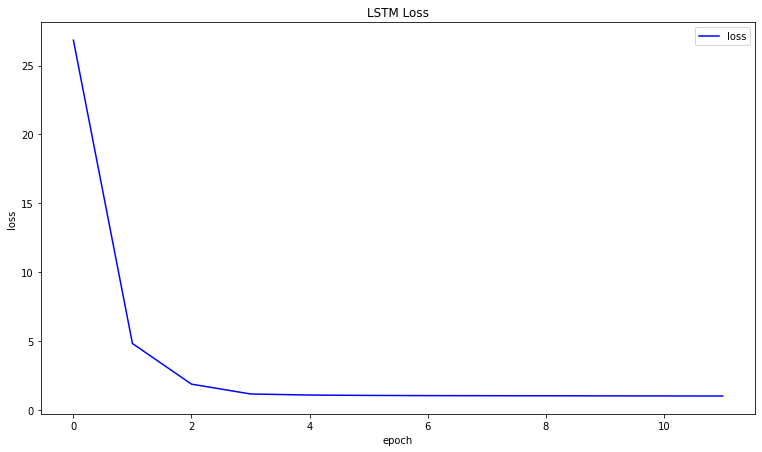

In [11]:
# plot loss
plt.plot(lstm_model.history.history["loss"], c="b")
plt.title("LSTM Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss"])
plt.show()


In [12]:
start = time.time()
# make predictions
preds = lstm_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
# preds = scaler.inverse_transform(preds)
end = time.time()

print("Time taken to predict: {:.4f} s".format(end - start))

Time taken to predict: 442.4367 s


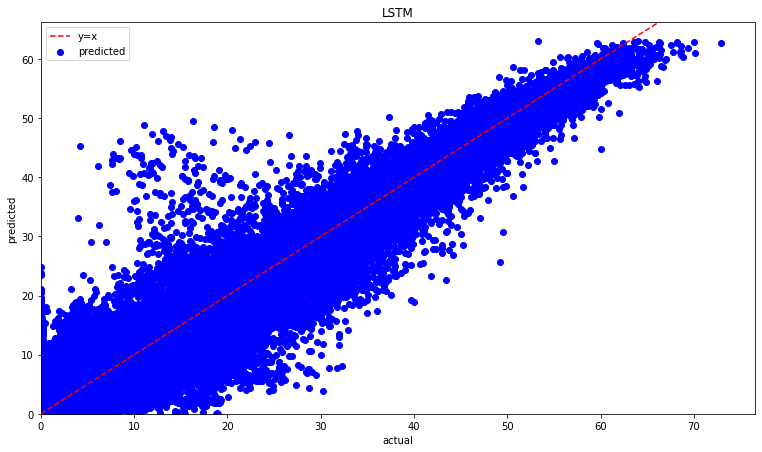

In [13]:
# plot results
plot_results(preds, y_test, "LSTM")


In [18]:
# performance metrics
performance_metrics(preds, y_test)


MSE: 0.9718
RMSE: 0.9858
MAE: 0.3808
WMAPE: 9.4423
R2: 0.9864


## ANN

Train the ANN model with the last 24 hours of the data.

In [15]:
def create_ann_model(X):
    """
    Build an ANN model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: ANN model
    """
    # define model
    model = Sequential()
    model.add(Dense(10, input_dim=X.shape[1], activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])
    return model


In [20]:
ann_model = create_ann_model(X_train)


In [40]:
ann_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 631
Trainable params: 631
Non-trainable params: 0
_________________________________________________________________


In [21]:
start = time.time()
# fit model
ann_model.fit(X_train, y_train, epochs=20, batch_size=1000)
end = time.time()

print("Time taken to train: {:.4f} s".format(end - start))


Epoch 1/20
6186/6186 [==============================] - 14s 2ms/step - loss: 1.2564 - mse: 1.2564
Epoch 2/20
6186/6186 [==============================] - 14s 2ms/step - loss: 0.9224 - mse: 0.9224
Epoch 3/20
6186/6186 [==============================] - 13s 2ms/step - loss: 0.8980 - mse: 0.8980
Epoch 4/20
6186/6186 [==============================] - 12s 2ms/step - loss: 0.8871 - mse: 0.8871
Epoch 5/20
6186/6186 [==============================] - 12s 2ms/step - loss: 0.8795 - mse: 0.8795
Epoch 6/20
6186/6186 [==============================] - 13s 2ms/step - loss: 0.8747 - mse: 0.8747
Epoch 7/20
6186/6186 [==============================] - 13s 2ms/step - loss: 0.8697 - mse: 0.8697
Epoch 8/20
6186/6186 [==============================] - 13s 2ms/step - loss: 0.8653 - mse: 0.8653: 0s - loss: 0.8651 - mse: 0.865
Epoch 9/20
6186/6186 [==============================] - 14s 2ms/step - loss: 0.8627 - mse: 0.8627
Epoch 10/20
6186/6186 [==============================] - 14s 2ms/step - loss: 0.8591 -

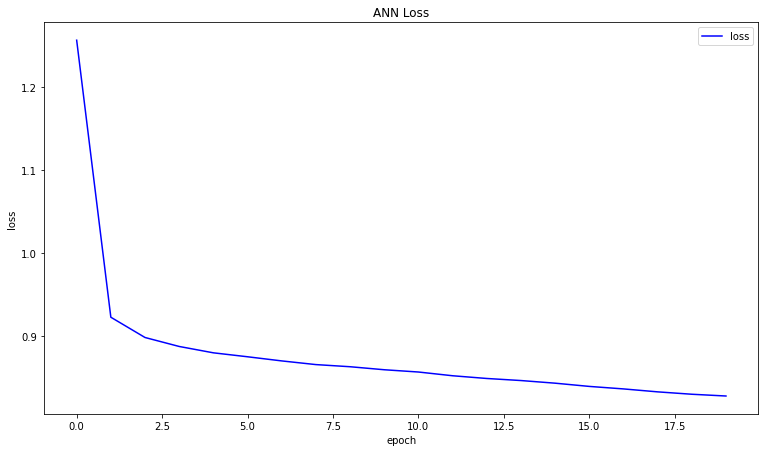

In [22]:
# plot loss
plt.plot(ann_model.history.history["loss"], c="b")
plt.title("ANN Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss"])
plt.show()


In [23]:
start = time.time()
# make predictions
preds = ann_model.predict(X_test)
end = time.time()

print("Time taken to predict: {:.4f} s".format(end - start))


Time taken to predict: 45.1752 s


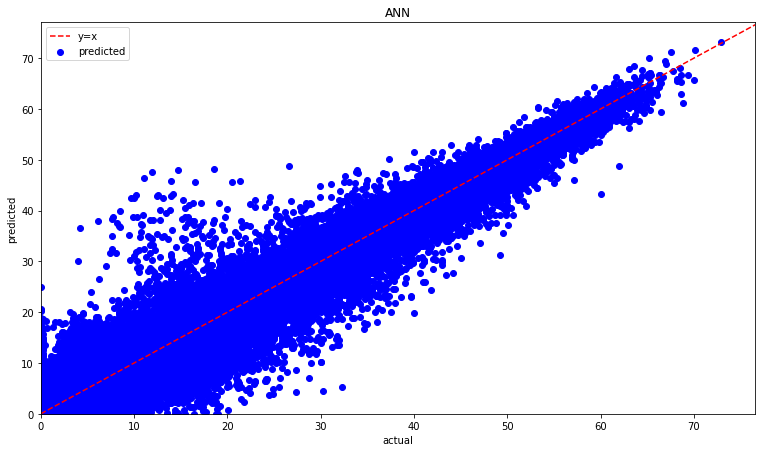

In [24]:
# plot results
plot_results(preds, y_test, "ANN")


In [25]:
# performance metrics
performance_metrics(preds, y_test)


MSE: 0.8107
RMSE: 0.9004
MAE: 0.3601
WMAPE: 8.9294
R2: 0.9886


## Gradient Boosting

Train the Gradient Boosting model with the last 5 hours of the data.

In [26]:
def create_gbdt_model():
    """
    Build an GBDT model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: GBDT model
    """
    # define model
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
    return model


In [27]:
gbdt_model = create_gbdt_model()


In [28]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])


In [29]:
start = time.time()
gbdt_model.fit(X_train, y_train)
end = time.time()

print("Time taken to train: {:.4f} s".format(end - start))


Time taken to train: 11676.7068 s


In [30]:
start = time.time()
# make predictions
preds = gbdt_model.predict(X_test)
end = time.time()

print("Time taken to predict: {:.4f} s".format(end - start))


Time taken to predict: 8.1269 s


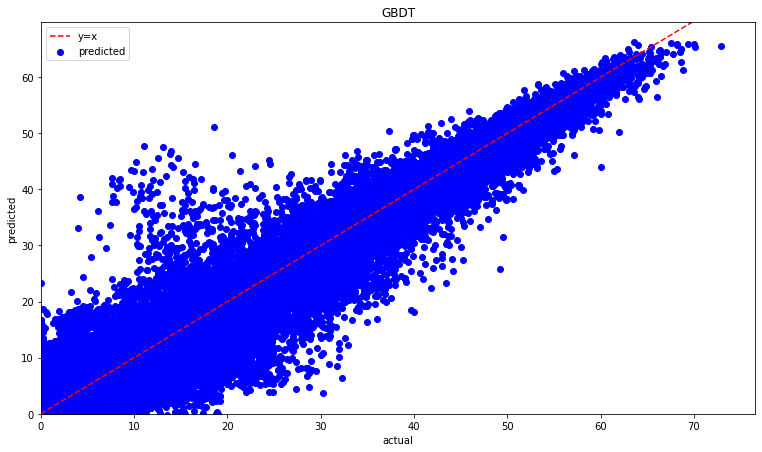

In [31]:
# plot results
plot_results(preds, y_test, "GBDT")


In [32]:
# performance metrics
performance_metrics(preds, y_test)


MSE: 0.9097
RMSE: 0.9538
MAE: 0.3683
WMAPE: 9.1313
R2: 0.9872


## XGBoost

Apply the XGBoost model with the last 18 hours of the data.

In [33]:
def create_xgboost_model():
    """
    Build an XGBoost model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: XGBoost model
    """
    # define model
    model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, verbosity=1, seed=42, tree_method="gpu_hist")
    return model


In [34]:
xgboost_model = create_xgboost_model()


In [35]:
start = time.time()
xgboost_model.fit(X_train, y_train)
end = time.time()

print("Time taken to train: {:.4f} s".format(end - start))


Time taken to train: 61.2720 s


In [36]:
start = time.time()
preds = xgboost_model.predict(X_test)
end = time.time()

print("Time taken to predict: {:.4f} s".format(end - start))


Time taken to predict: 2.0815 s


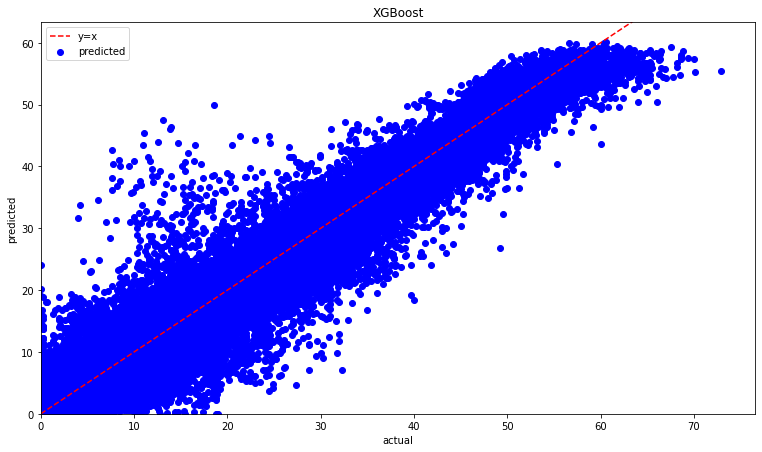

In [37]:
# plot results
plot_results(preds, y_test, "XGBoost")


In [38]:
# performance metrics
performance_metrics(preds, y_test)


MSE: 0.7901
RMSE: 0.8889
MAE: 0.3485
WMAPE: 8.6405
R2: 0.9889


## Random Forest

In [5]:
def create_random_forest_model():
    """
    Build an Random Forest model
    """
    # define model
    model = RandomForestRegressor(n_estimators=100, max_depth=4, n_jobs=-1, random_state=42)
    return model

In [6]:
rf_model = create_random_forest_model()


In [7]:
import time

start = time.time()
rf_model.fit(X_train, y_train)
end = time.time()

print("Time taken to train: {:.4f} s".format(end - start))


In [ ]:
start = time.time()
preds = rf_model.predict(X_test)
end = time.time()

print("Time taken to predict: {:.4f} s".format(end - start))


In [ ]:
# plot results
plot_results(preds, y_test, "Random Forest")


In [ ]:
# performance metrics
performance_metrics(preds, y_test)
